In [18]:
import yfinance as yf
import numpy as np
import pandas as pd
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

class TimeSeriesModel:
    def __init__(self, time_series, significance_level=0.05):
        """
        Initialize the class with the time series data and significance level for model evaluation.
        
        :param time_series: pandas Series representing the time series.
        :param significance_level: The significance level for model evaluation.
        """
        self.time_series = time_series
        self.significance_level = significance_level
        self.model = None
        self.residuals = None
    
    def is_stationary(self):
        """
        Perform the Augmented Dickey-Fuller (ADF) test to check if the series is stationary and plot the PACF.
        
        :return: True if the series is stationary, False otherwise.
        """
        adf_result = sm.tsa.adfuller(self.time_series)
        p_value = adf_result[1]
        
        # PACF Plot
        self.plot_pacf()
        
        return p_value < self.significance_level

    def plot_pacf(self):
        """
        Plot the PACF to visually inspect if the time series is stationary.
        """
        plt.figure(figsize=(10, 6))
        sm.graphics.tsa.plot_pacf(self.time_series, lags=40, method='ywm')
        plt.title("Partial Autocorrelation Function (PACF)")
        plt.show()

    def difference(self, order=1):
        """
        Difference the series to make it stationary.
        
        :param order: Order of differencing (default is 1).
        :return: Differenced time series.
        """
        self.time_series = self.time_series.diff(order).dropna()
        return self.time_series
    
    def select_best_arima(self, max_p=5, max_q=5, max_d=2):
        """
        Automatically select the best ARIMA model using stepwise search via pmdarima's auto_arima.
        
        :param max_p: Maximum order of AR.
        :param max_d: Maximum differencing.
        :param max_q: Maximum order of MA.
        :return: Best ARIMA model based on AIC.
        """
        print("Performing stepwise search for best ARIMA model...")
        
        try:
            stepwise_model = pm.auto_arima(
                self.time_series,
                start_p=0, start_q=0,
                max_p=max_p, max_d=max_d, max_q=max_q,
                seasonal=False,
                trace=True,  # Print each iteration
                error_action='ignore',  # Ignore failed models
                suppress_warnings=True,
                stepwise=True,
                d=None,  # Automatically determine the differencing value
                max_order=max_p + max_q + max_d
            )
        except ValueError as e:
            print(f"Error occurred during auto_arima selection: {e}")
            return None
        
        self.model = ARIMA(self.time_series, order=stepwise_model.order).fit()
        self.residuals = self.model.resid
        print(f"Selected ARIMA model: {stepwise_model.order} with AIC: {stepwise_model.aic()}")
        
        return self.model
    
    def simulate_forecast(self, num_simulations=10000, forecast_periods=10):
        """
        Simulate forecasts of the time series model.
        
        :param num_simulations: Number of forecast simulations.
        :param forecast_periods: Number of forecast periods ahead.
        :return: Simulated forecasts (2D array of size num_simulations x forecast_periods).
        """
        forecast_results = np.zeros((num_simulations, forecast_periods))
        
        # KDE for residuals to simulate noise matching the residual distribution
        kde = gaussian_kde(self.residuals)
        
        # Simulate forecasts
        for i in range(num_simulations):
            noise_term = kde.resample(forecast_periods).flatten()  # Sample residuals as noise
            forecast = self.model.forecast(steps=forecast_periods)
            
            # Use .values to correctly access the forecast array
            forecast_values = forecast.values + noise_term  # Add sampled noise
            
            forecast_results[i, :] = forecast_values
        
        return forecast_results
    
    def percent_exceed(self, simulations, threshold):
        """
        Calculate the percentage of simulations that exceed a user-specified value in each forecast period.
        
        :param simulations: 2D array of forecast simulations (from simulate_forecast).
        :param threshold: Value that simulations are compared against.
        :return: Percent of simulations exceeding the threshold in each forecast period.
        """
        return np.mean(simulations > threshold, axis=0)

    def plot_cumulative_returns(self, forecast_periods=10):
        """
        Plot the cumulative returns for the actual and predicted series, limited to the range from 2010 onwards.
        
        :param forecast_periods: Number of forecast periods ahead.
        """
        # Actual cumulative returns (buy-and-hold returns)
        actual_returns = self.time_series.pct_change().dropna()
        actual_cumulative_returns = (1 + actual_returns).cumprod()
        
        # Filter actual returns from 2010 onwards
        actual_cumulative_returns = actual_cumulative_returns[actual_cumulative_returns.index >= '2010-01-01']
        
        # Forecast future values using the model
        forecast = self.model.forecast(steps=forecast_periods)
        forecast_index = pd.date_range(start=self.time_series.index[-1] + pd.Timedelta(days=1), periods=forecast_periods, freq='B')
        
        # Create DataFrame for forecasted values
        forecast_df = pd.Series(forecast, index=forecast_index)
        
        # Debug: Check the forecast values and their length
        print("Forecast Values:", forecast_df.values)
        print("Forecast Length:", len(forecast_df))
        
        # Calculate predicted returns based on forecast
        predicted_returns = forecast_df.pct_change().dropna()
        
        # Debug: Check predicted returns and their length
        print("Predicted Returns:", predicted_returns.values)
        print("Predicted Returns Length:", len(predicted_returns))
        
        # Calculate predicted cumulative returns, starting from the last actual cumulative return
        last_actual_return = actual_cumulative_returns.iloc[-1]
        predicted_cumulative_returns = (1 + predicted_returns).cumprod()
        
        # Adjust predicted cumulative returns to start from the last actual cumulative return
        predicted_cumulative_returns = predicted_cumulative_returns.add(last_actual_return)

        # Set the index for predicted cumulative returns
        # Align the index correctly based on the length of predicted_cumulative_returns
        predicted_cumulative_returns.index = forecast_index[1:len(predicted_cumulative_returns) + 1]  

        # Debug: Check the predicted cumulative returns
        print("Predicted Cumulative Returns:", predicted_cumulative_returns)
        
        # Plot actual vs predicted cumulative returns
        plt.figure(figsize=(12, 8))
        sns.lineplot(x=actual_cumulative_returns.index, y=actual_cumulative_returns, label="Actual Cumulative Returns", color="blue")
        sns.lineplot(x=predicted_cumulative_returns.index, y=predicted_cumulative_returns, label="Predicted Cumulative Returns", color="orange")
        plt.title("Actual vs Predicted Cumulative Returns (Buy and Hold) - From 2010")
        plt.ylabel("Cumulative Returns")
        plt.xlabel("Date")
        plt.legend()
        plt.show()


[*********************100%***********************]  1 of 1 completed


<Figure size 1000x600 with 0 Axes>

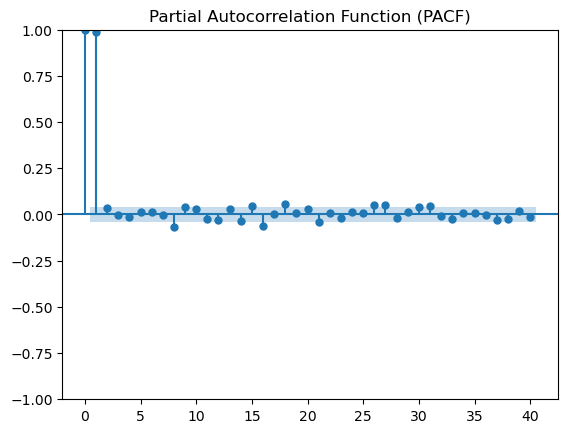

Is Stationary: False


<Figure size 1000x600 with 0 Axes>

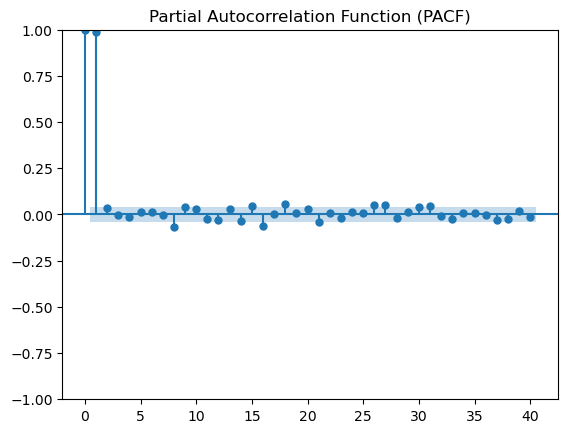

Performing stepwise search for best ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12218.718, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11366.996, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12216.724, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10977.478, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=10818.578, Time=0.23 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=10788.645, Time=0.39 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=10766.079, Time=0.44 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=10270.888, Time=1.61 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.66 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=10270.787, Time=0.64 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.52 se

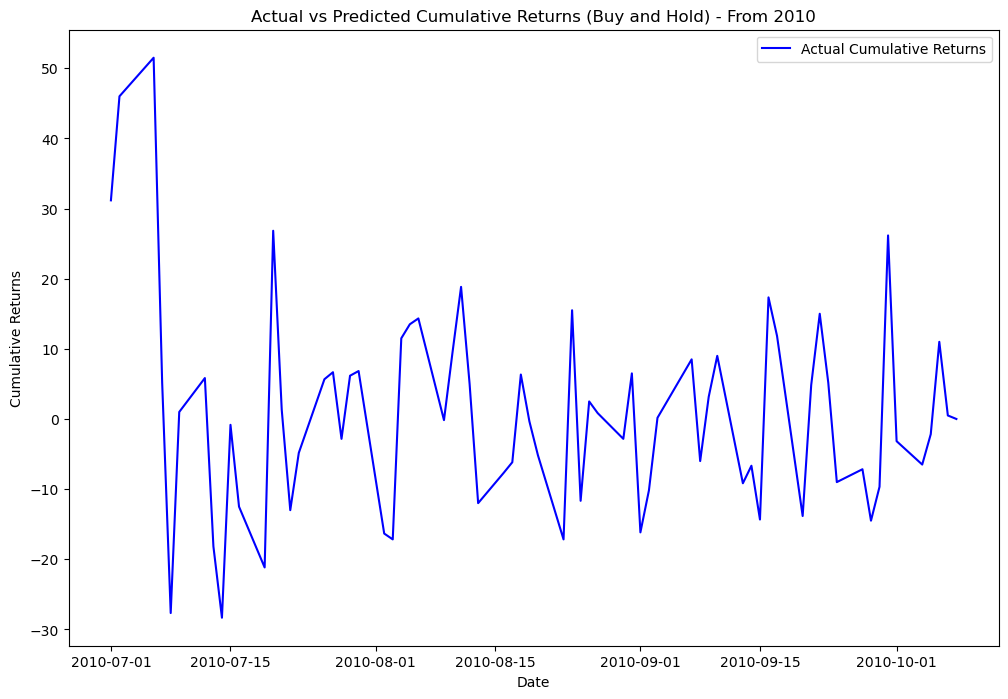

In [19]:

# Fetching Google stock data using yfinance (GOOGL is the ticker for Alphabet Inc)
yahoo_stock = yf.download('TSLA', start='2010-01-01', end='2020-12-31')

# Use the 'Close' price for time series modeling
time_series = yahoo_stock['Close'].dropna()

# Initialize the time series model
ts_model = TimeSeriesModel(time_series)

# Check if the series is stationary
print("Is Stationary:", ts_model.is_stationary())

# If not stationary, difference the series
if not ts_model.is_stationary():
    ts_model.difference()

# Select and fit the best ARIMA model
best_model = ts_model.select_best_arima()
if best_model:
    print("Best ARIMA Model Summary:")
    print(best_model.summary())

# Simulate forecasts
simulations = ts_model.simulate_forecast(num_simulations=10000, forecast_periods=10)

# Calculate the percent of simulations exceeding a certain threshold
threshold_value = 1500  # Example threshold for Google stock price
percent_exceed = ts_model.percent_exceed(simulations, threshold=threshold_value)
print(f"Percent of simulations exceeding {threshold_value} in each period:")
print(percent_exceed)

# Plot cumulative returns for actual and predicted series
ts_model.plot_cumulative_returns(forecast_periods=10)